In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'psd'
model_setting = 'conv1d'

d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 0.70 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.46 seconds.
['20170212', '20170211', '20170209', '20170208', '20170210', '20170207', '20170213', '20161213', '20170206', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.47 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.46 seconds.
['20170131', '20170317', '20170318', '20170320', '20170205', '20170203', '20170204', '20170202', '20170319', '20170313', '20170201', '20170314', '20170316', '20170130', '20170206', '20170315']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.46 seconds.
['20170121', '20170120', '20170123', '20170118', '20170117', '20170119', '20170116', '20170122', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Rea

{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

## Choosing model (6 classes or 3-merged)

In [2]:
merged = True

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

############ INPUT SHAPE:(4097, 1)


In [3]:
d.target_classes

['Aedes', 'Anopheles', 'Culex']

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4095, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4093, 16)          784       
_________________________________________________________________
batch_normalization (BatchNo (None, 4093, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4091, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4089, 32)          3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4089, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2044, 32)          0

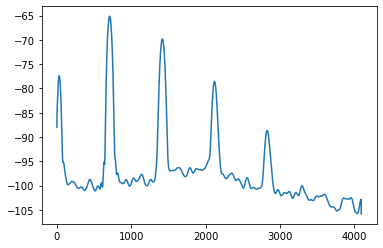

In [39]:
plt.plot(10*np.log10(next(valid_generator(X_val, y_val,
                batch_size=traincf.batch_size,
                target_names=traincf.target_names,
                setting=traincf.setting,
                preprocessing_train_stats='',
                using_conv2d=using_conv2d))[0][0,:,:]))

In [8]:
pd.Series(y_val).value_counts()

0    20085
2    13980
1    11673
dtype: int64

### Model training

In [6]:
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=traincf.target_names,
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=traincf.target_names,
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5718 steps, validate for 1478 steps
Epoch 1/100
1501/5718 [======>.......................] - ETA: 8:50 - loss: 1.0684 - accuracy: 0.4400WARNING:tensorflow:Can save best model only with val_loss available, skipping.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-e822a8809f1b>", line 16, in <module>
    callbacks=traincf.callbacks_list)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 342, in fit


KeyboardInterrupt: 

In [ ]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [8]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=traincf.target_names,
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [9]:
features.shape

(47295, 3)

### Confusion matrix (test set)

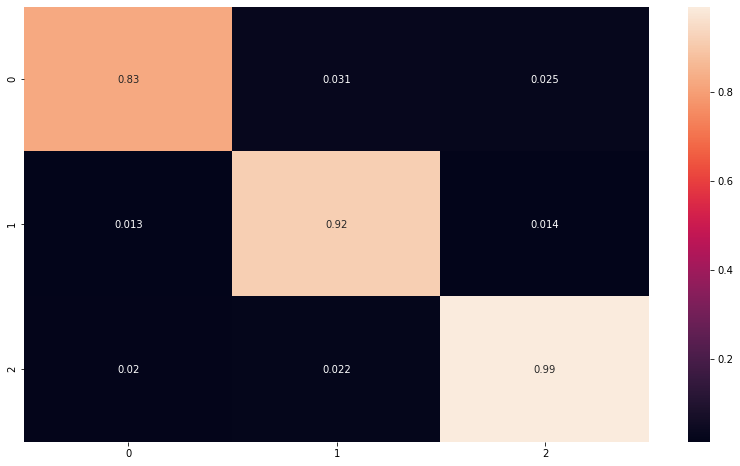

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(14,8))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)#, fmt='g')

In [11]:
pd.Series(y_test).value_counts()

2    35109
1     6831
0     5355
dtype: int64

In [12]:
pd.Series(np.argmax(features, axis=1)).value_counts()

2    34040
1     7026
0     6229
dtype: int64